In [1]:
### 导入依赖库
import os, cv2, random
import numpy as np

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.layers import Input, Dense
from keras.optimizers import Adam,RMSprop 
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras import backend as K
K.set_image_data_format('channels_last') # 数据格式data_format设置为 NHWC

Using TensorFlow backend.


In [2]:
#下载数据压缩包，解压，然后清理压缩包。

from modelarts.session import Session
session = Session(username='***',  password='***', region_name='cn-north-4')

if session.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz"
elif session.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_image_recognition/image_recognition.tar.gz"
else:
    print("请更换地区到北京一或北京四")

In [3]:
if not os.path.exists('./data'):
    session.download_data(
    bucket_path= bucket_path,
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

In [4]:
DATA_DIR = './data/' # 数据集路径

# 目标缩放尺寸
ROWS = 32
COLS = 32
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


In [5]:
num_train_samples = len(image_file_names)
num_classes = 2 # 类别数是2
labels = []

index = 0
for filename in image_file_names:
    if 'dog' in filename:
        labels.append(1)
    elif 'cat' in filename:
        labels.append(0)
        
# 把类别标签转换为onehot编码
labels = np_utils.to_categorical(labels, num_classes)

In [6]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.30, random_state=10)

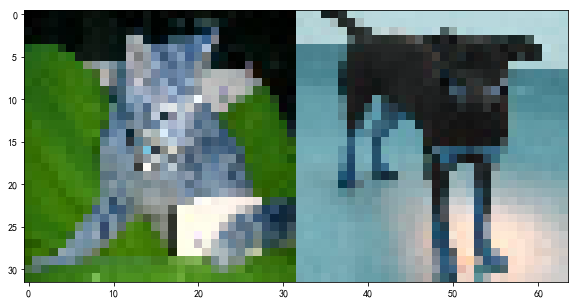

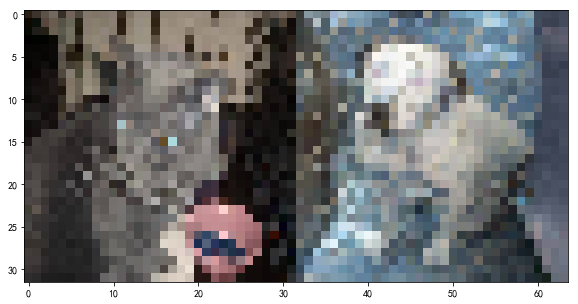

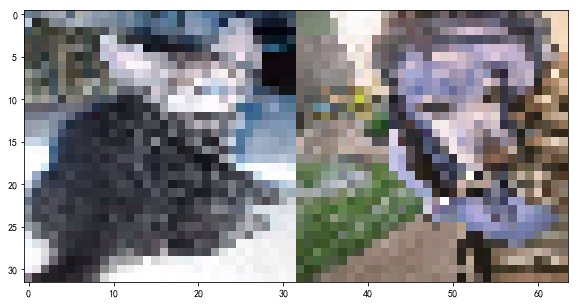

In [7]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

In [8]:
##设置超参
batch_size = 32 # 批大小
learning_rate = 1e-4 # 设置学习率为1e-4

In [9]:
optimizer = Adam(lr=learning_rate) # 优化器使用 RMSprop 
objective = 'binary_crossentropy' # loss 函数使用交叉熵
def load_model():
    # 这是一个模型参数随机初始化的模型，如果想要加载imagenet预训练模型，可以设置 weights='imagenet'
    base_model = VGG16(include_top=False, weights=None, input_shape=(ROWS, COLS, CHANNELS), pooling='avg')
    
    # 修改base_model的模型输出层
    prediction_layer = Dense(2, activation='softmax')(base_model.output)
    
    # 组装成新的模型
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    
    # 模型编译
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model
model = load_model()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [11]:
epochs = 15 # 训练轮数

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')   

def run_train():
    
    # 开始训练
    history = model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.25,  # 训练数据中，抽取25%的数据作为验证数据
        verbose=1,
        shuffle=True,
        callbacks=[early_stopping]) 
    return history

history = run_train()

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 13125 samples, validate on 4375 samples
Epoch 1/15
13125/13125 [==============================] - 57s 4ms/step - loss: 0.6902 - acc: 0.5290 - val_loss: 0.6828 - val_acc: 0.5611
Epoch 2/15
13125/13125 [==============================] - 31s 2ms/step - loss: 0.6577 - acc: 0.6029 - val_loss: 0.6498 - val_acc: 0.6046
Epoch 3/15
13125/13125 [==============================] - 41s 3ms/step - loss: 0.5599 - acc: 0.7150 - val_loss: 0.5390 - val_acc: 0.7241
Epoch 4/15
13125/13125 [==============================] - 36s 3ms/step - loss: 0.4857 - acc: 0.7660 - val_loss: 0.5247 - val_acc: 0.7449
Epoch 5/15
13125/13125 [==============================] - 40s 3ms/step - loss: 0.4175 - acc: 0.8095 - val_loss: 0.4592 - val_acc: 0.7874
Epoch 6/15
13125/13125 [==============================] - 34s 3ms/step - loss: 0.3493 - acc: 0.8424 - val_loss: 0.4905 - val_acc: 0.7630
Epoch 7/15
13125/13125 [==============================] - 42s 3ms/step - loss: 0.2759 - acc: 0.8846 - val_loss: 0.5831 - val_acc:

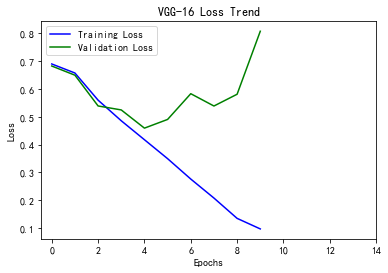

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

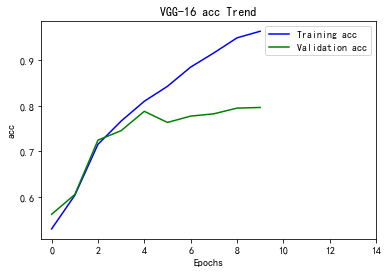

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('VGG-16 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

In [14]:
predictions = model.predict(test_data, verbose=0)

I am 100.00% sure this is a Dog


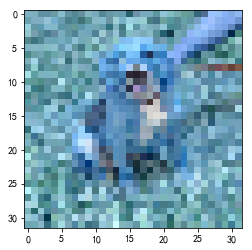

I am 99.46% sure this is a Dog


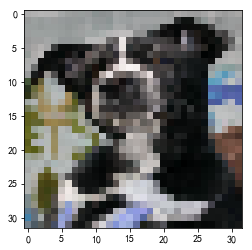

I am 99.21% sure this is a Cat


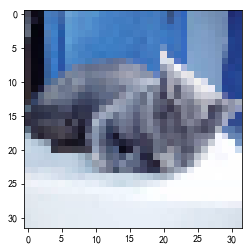

I am 100.00% sure this is a Cat


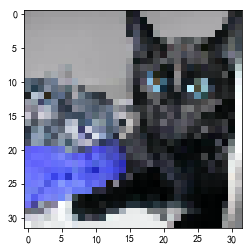

I am 100.00% sure this is a Dog


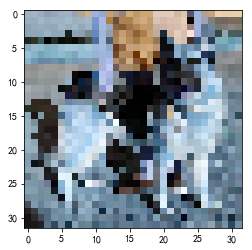

I am 99.93% sure this is a Dog


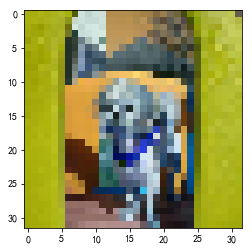

I am 100.00% sure this is a Cat


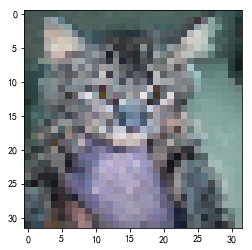

I am 100.00% sure this is a Dog


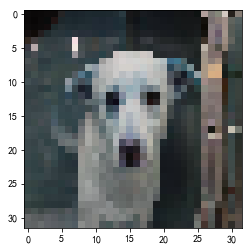

I am 99.74% sure this is a Dog


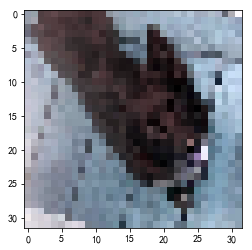

I am 96.80% sure this is a Cat


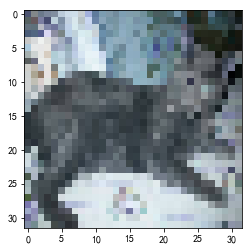

In [15]:
for i in range(0,10):
    p = predictions[i]
    
    if round(p[1]) == 1: 
        print('I am {:.2%} sure this is a Dog'.format(p[1]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - p[1]))
        
    plt.imshow(test_data[i])
    plt.show()

In [16]:
predictions_test_array = []
test_label_array = []

# 将onehot编码的数据进行格式转换
for p in predictions:
    if round(p[1]) == 1:
        predictions_test_array.append(1)
    else:
        predictions_test_array.append(0)
        
for t in test_label:
    if int(t[1]) == 1:
        test_label_array.append(1)
    else:
        test_label_array.append(0)
        
acc = accuracy_score(test_label_array, predictions_test_array)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.793067


减小图片输入像素尺寸，也会不利于识别。